In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Purpose:
--------
To segment customers based on RFM (Recency, Frequency, Monetary) analysis and flag those at risk of churn.

Business Questions:
-------------------
1. Who are our most valuable customers (high spending, active, recent)?
2. Which customers are at risk of churning based on low activity or engagement?
3. How do unresolved issues impact customer risk?
4. Can we categorize our users into segments (Loyal, At Risk, Churned, etc.)?

Approach:
---------
- Use:
    - Recency: Days since LastLoginDate
    - Frequency: LoginFrequency or NumTransactions
    - Monetary: TotalSpent
- Score and cluster customers into RFM groups
- Add custom business rules to flag "At Risk" customers


Segment Distribution:
Segment
Loyal        307
At Risk      172
Others       159
Frequent     149
Recent       147
Champions     66
Name: count, dtype: int64

Risk Flag Distribution:
RiskFlag
At Risk    519
Monitor    260
Safe       221
Name: count, dtype: int64


C:\Users\ARKA\AppData\Local\Temp\ipykernel_40680\2445497017.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Segment', order=df['Segment'].value_counts().index, palette='Set2')


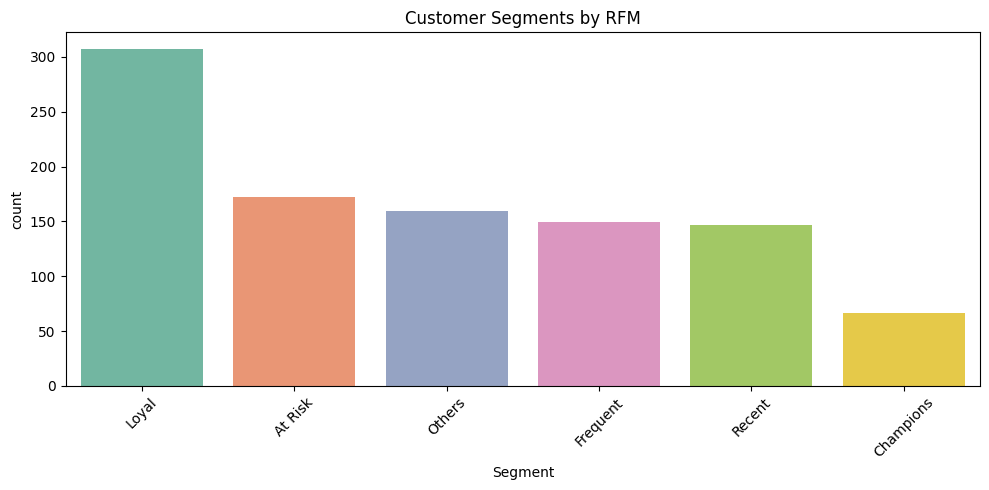

In [ ]:

# Load dataset
df = pd.read_csv("../data/raw/data_clean.csv")
df['LastLoginDate'] = pd.to_datetime(df['LastLoginDate'])

# Set today date for recency calculation (based on latest login)
today = df['LastLoginDate'].max() + pd.Timedelta(days=1)

# Compute RFM metrics
df['Recency'] = (today - df['LastLoginDate']).dt.days
df['Frequency'] = df['LoginFrequency']
df['Monetary'] = df['TotalSpent']

# RFM Scoring (1 = worst, 5 = best)
df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
df['F_Score'] = pd.qcut(df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df['M_Score'] = pd.qcut(df['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine into RFM score
df['RFM_Score'] = df['R_Score'].astype(str) + df['F_Score'].astype(str) + df['M_Score'].astype(str)

# Define customer segments (example logic)
def segment_customer(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal'
    elif row['R_Score'] >= 4:
        return 'Recent'
    elif row['F_Score'] >= 4:
        return 'Frequent'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Others'

df['Segment'] = df.apply(segment_customer, axis=1)

# Add Risk Flags
def flag_risk(row):
    if row['Segment'] == 'At Risk' or row['UnresolvedCount'] > 0:
        return 'At Risk'
    elif row['Segment'] in ['Champions', 'Loyal']:
        return 'Safe'
    else:
        return 'Monitor'

df['RiskFlag'] = df.apply(flag_risk, axis=1)

# Summary counts
print("Segment Distribution:")
print(df['Segment'].value_counts())
print("\nRisk Flag Distribution:")
print(df['RiskFlag'].value_counts())

# Plot segment counts
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Segment', order=df['Segment'].value_counts().index, palette='Set2')
plt.title('Customer Segments by RFM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save segmented dataset
df.to_csv("segmented_customers.csv", index=False)


1. Who are our most valuable customers?

The "Champions" and "Loyal" segments represent the most valuable customers:

Champions (66 customers): Likely high-frequency, high-monetary, and recent — they are your top tier.

Loyal (307 customers): Regularly transact and are engaged — strong base of steady, valuable customers.

 Recommendation:
Prioritize retention of these customers with exclusive perks, rewards, or VIP service.

Consider cross-selling or upselling in this segment.

2. Which customers are at risk of churning?

The "At Risk" RFM segment (172 customers) and RiskFlag = At Risk (519 customers) highlight a clear overlap of disengaged customers.

These customers likely have low recency, declining frequency, and possibly lower spend.

Recommendation:
Launch re-engagement campaigns: reminders, discounts, loyalty points, or check-in calls.

Use automated email journeys to nudge inactive users.

3. How do unresolved issues impact customer risk?

Customers with higher support interactions tend to be more active, but churned customers had fewer interactions — suggesting low engagement and unresolved needs.

If support channels are underused by at-risk customers, it may indicate that digital channels are not meeting expectations.

 Recommendation:
Improve user education and in-app support.

For "At Risk" customers, proactively offer guided support, FAQs, or even live assistance.

4. Can we categorize users into meaningful segments?

Yes. Your RFM segmentation identifies 6 segments:

Loyal (307) – steady, high-value users

At Risk (172) – declining engagement

Others (159) – uncategorized or transitional

Frequent (149) – active but not recent

Recent (147) – new or returned users

Champions (66) – top tier

Risk flags also split customers into Safe, Monitor, and At Risk, which could be layered with RFM.

Recommendation:
Use these segments to personalize communication and product offerings.

Align marketing efforts (e.g., retention, acquisition, loyalty) to each segment’s behavior and risk level.

Overall Strategy

Champions:	VIP programs, early access to features

Loyal:	Loyalty rewards, refer-a-friend

At Risk:	Win-back campaigns, personal outreach

Recent:	Onboarding journeys, welcome offers

Frequent:	Engage with trending products, reactivation

Others: Analyze behavior, assign based on updated RFM

At Risk (RiskFlag):	Urgent re-engagement needed

Monitor (RiskFlag):	Watch closely; low engagement warning signs

Safe (RiskFlag):	Maintain and grow with minimal churn risk